# Other operations on functions in the MW basis

As already described, we have two complementary representations of functions
* Reconstructed:
$$f(x) = \sum_l \sum_i s^{N_{max}+1}_{il} \phi^n_{il}(x)$$
* Compressed:
$$f(x) = \sum_i s^{N_0}_i \phi^0_i(x) + \sum_{n=N_{min}}^{N_{max}} \sum_l \sum_i d^n_{il} \psi^n_{il}(x)$$

There is a third representation, which is the value of the function tabluated at the Gauss-Legendre quadrature points. Transforming from the scaling function coefficients to the function values is fast and accurate. Note that if instead of using Legendre polynomials as the scaling functions one picked the interpolating polynomials, then the scaling function coefficients would be the function values.

When applying an operator to a function one picks the most efficient/convenient representation.  Note that the fast wavelet transform plays exactly the same role as does the fast Fourier transform does in plane wave calculations in which you switch between a real-space grid of function values and a Fourier-space grid of plane-wave coefficients.
*  In plane-wave calculations some operators are diagonal in real space (e.g., multiplication of functions) or diagonal in Fourier space (e.g., differentiation, application of the Coulomb Green's function).  But the price is that the basis is global and there is no adaptive refinement.
* In the wavelet basis, some operators are nearly-diagonal in real space (e.g., differentiation, multiplication) or nearly diagonal in wavelet space (e.g., application of the Coulomb Green's function).  The benefit from this tradeoff is adaptive refinement.

*Scaling by a constant:* In any representation, just scale the coefficients/values.

*Addition and substraction of functions:*  This can be peformed in any of the representations, with some clean up afterwards.  
  * In the wavelet basis, one simply adds coefficients.  This is because the wavelet functions are orthogonal both within and between scales.
  * In the scaling function basis and if the two input functions have an identical pattern of adaptive refinement,  one can again just add coefficients.  However, since the scaling functions are only orthogonal within the same scale, if the refinement patterns differ, adding the coefficients will produce a non-standard representation with scaling function coefficients at multiple levels in the tree.  This can be fixed up after the addition by summing the coefficients down the tree using the two-scale relationship.  
  * The preferred approach depends on the context.  If you are just adding up a bunch of functions to produce a single result, it is fastest to just use the representation you are in and fix up the result as needed.  If performing a linear transformation of a vector of functions, it is perhaps fastest to first transform into the compressed form.
  * The result is exact within usual machine round off errors.

*Multiplication of functions:* This is most readily composed using the function-value representation in which we naively just multiply corresponding function values at the Gauss-Legendre grid points.  However, there are three things that make this more complicated.
  1. Adaptive refinement:  If the input functions differ in their refinement levels, one has to use the two-scale relationship to recur the coefficients of the least refined tree down to the level of the more deeply refined tree.  In practice, one walks down the union of the two trees and directly computes the values of the coarser-scale polynomials at the Gauss-Legendre quadrature points at the finer scale.  
  2. Sparsity: Consider multiplying two disjoint functions --- i.e., two functions that have no non-zero values in common.  Their product is indentically zero.  However, the algorithm described above would produce a tree that is the union of the inputs.  Similarly, consider multiplying two functions that only have small tails that overlap.  Most of the product might be below the trunction threshold, yet the algorithm will again compute everything.  For thresholding, one first walks up the tree of each function to compute in each box of tree the norm of each input function.  Then the product is computed as described by walking down the union of trees but now with knowledge of the norm of the result so that the traversal can be stopped as appropriate.
  3. Maintaining accuracy: While it innocently seems as if we are multiplying function values at the quadrature points within each adaptively refined box, what we are really doing is multiplying two polynomials of degree $k-1$.  Thus, the exact product is of degree $2k-2$.  But we are representing the result in the degree $k-1$ basis.  I.e., there is a truncation error in the product.  One can estimate this trunction error and refine to compute the product at a lower level as needed.  Beylkin gives a concise argument that you at most need to only refine down one level, assuming that you have already adequately sampled each of the input functions.  Consider multiplying two plane waves $\exp(i \omega x) * \exp(i \omega x) = \exp(i 2 \omega x)$, with $\omega = 2 \pi / h = 2 \pi 2^n / L$ (in which $h$ is the size of a box at level $n$ and $L$ is the overall domain size).  Thus, the product naturally lives one level down.
  
*Non-linear functions of a function:* We've already looked at multiplication.  Other non-linear unary (e.g., $\exp(f(x)$ or $\sqrt{f(x)}$) and binary (e.g., $f(x)^{g(x)}$ work similarly, though different analyis is necessary to maintain accuracy.  Some care is needed in handling numerical noise that can take a function outside its anticipated valid range of values.  For instance, consider a density computed as $\rho(r) = \sum_i \phi_i(r)^2$.  We expect this to be positive everywhere.  However, due to truncation error, the values could be negative where the function value falls below the truncation threshold. More challenging, when computing $|\nabla \rho|/\rho$, as required in GGA DFT functionals, we need to manage possibly uncorrelated numerical noise in both $|\grad \rho|$ and $\rho$.  Instead, one can note that $|\nabla \rho|/\rho = |\nabla \log \rho|$, as suggested by Bischoff.  Thus, you can see that some thought and reformulation can be helpful in practice.

**Exercise:**
* In 3D, $f(r,c,a) = (a/\pi)^{3/2} \exp(-a |r-c|^2)$ is a Gaussian centered at $c$ with exponent $a$ normalized so its integral is unity.
* The [Gaussian Product Theorem](https://molssi.github.io/MIRP/gaussian_product_theorem.html#:~:text=The%20Gaussian%20Product%20Theorem%20(GPT,quantum%20chemistry%20to%20simplify%20integrals.) tells us that the product of two Gaussians is another Gaussian
  - $f(r,c,a) f(r,d,b) =  \exp(ab|c-d|^2 / (a+b))f(r,(ac - bd)/(a+b)) $
* Project two 3D Gaussian test functions with different exponents and centers and also directly project their product.
* Demonstrate that addition of two functions is exact within expected numerical error due to machine precision.
* Explore (using both plots and function norms) as a function of their exponents, centers, and the truncation threshold the errors of the numerically computed product (i.e., compute the product and compare it against the directly computed result) including when the product becomes negligible as the Gaussians barely overlap.

**Exercise:**
* In 1D, project a Gaussian to low precision and examine the nature of the noise and how and where it can be negative.


In [11]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from vampyr import vampyr1d as vp1
from vampyr import vampyr2d as vp2
from vampyr import vampyr3d as vp3
from plotter import grid_plotter

MRA = vp3.MultiResolutionAnalysis(box=[-16, 16], order=5)
prec = 1.0e-3
P_eps = vp3.ScalingProjector(MRA, prec)

b = 0.5
a = (b/np.pi)**(3./2.)
center = [3.0, 0.0, 0.0]
power = [0, 0, 0]
wideG = vp3.GaussFunc(b, a, center, power)

b = 2.0
a = (b/np.pi)**(3./2.)
center = [-3.0, 0.0, 0.0]
power = [0, 0, 0]
narrowG = vp3.GaussFunc(b, a, center, power)

wideG_tree = P_eps(wideG)
narrowG_tree = P_eps(narrowG)

sum_tree = 2*wideG_tree + 3*narrowG_tree

In [12]:
print(wideG_tree)
print(narrowG_tree)
print(sum_tree)


*FunctionTree: nn
  genNodes: 0
  square norm: 0.0224484
  root scale: -4
  order: 5
  nodes: 680
  endNodes: 596
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=96
    scale=-1  nodes=512


*FunctionTree: nn
  genNodes: 0
  square norm: 0.179587
  root scale: -4
  order: 5
  nodes: 520
  endNodes: 456
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=32
    scale=-2  nodes=32
    scale=-1  nodes=64
    scale=0  nodes=384


*FunctionTree: nn
  genNodes: 0
  square norm: 1.70608
  root scale: -4
  order: 5
  nodes: 1096
  endNodes: 960
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=96
    scale=-1  nodes=544
    scale=0  nodes=384



(<Figure size 900x900 with 1 Axes>, <Axes3DSubplot:>)

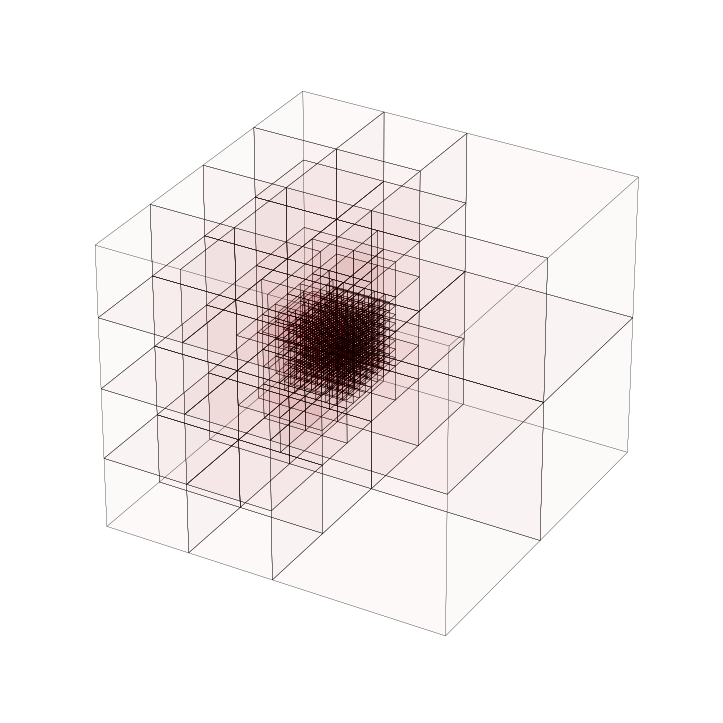

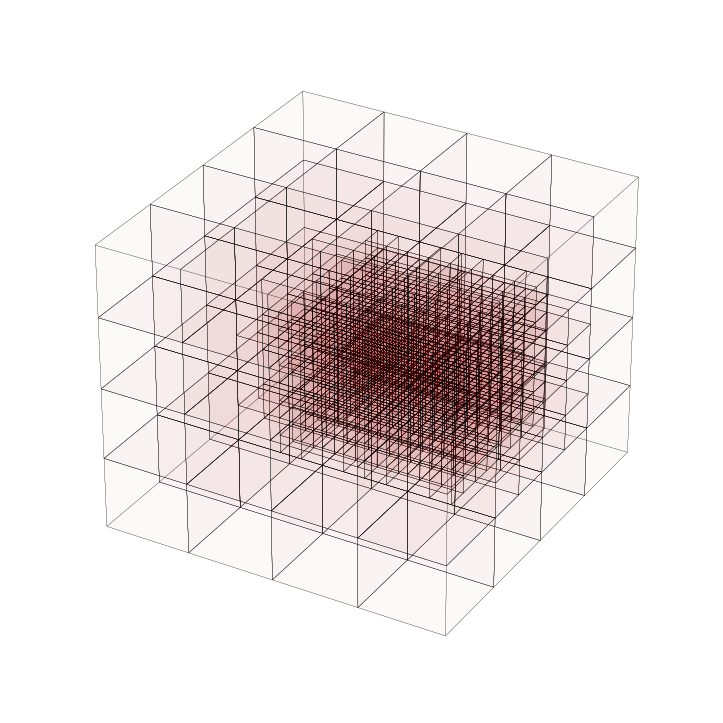

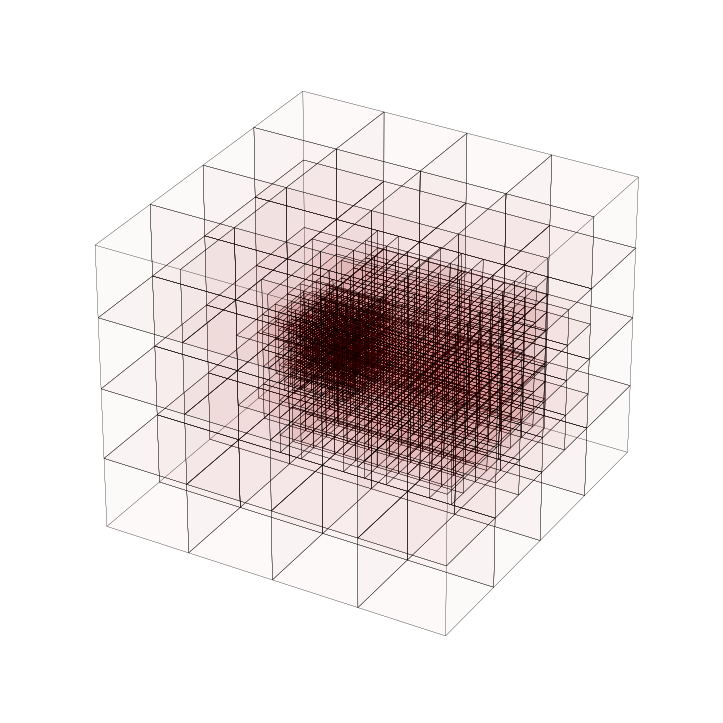

In [13]:
from plotter import grid_plotter
grid_plotter(narrowG_tree)
grid_plotter(wideG_tree)
grid_plotter(sum_tree)


*FunctionTree: nn
  genNodes: 0
  square norm: 1.60958e-16
  root scale: -4
  order: 5
  nodes: 8776
  endNodes: 7680
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=512
    scale=-1  nodes=768
    scale=0  nodes=4352
    scale=1  nodes=3072


*FunctionTree: nn
  genNodes: 0
  square norm: 1.60958e-16
  root scale: -4
  order: 5
  nodes: 296
  endNodes: 260
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=32
    scale=-2  nodes=32
    scale=-1  nodes=32
    scale=0  nodes=64
    scale=1  nodes=128



(<Figure size 900x900 with 1 Axes>, <Axes3DSubplot:>)

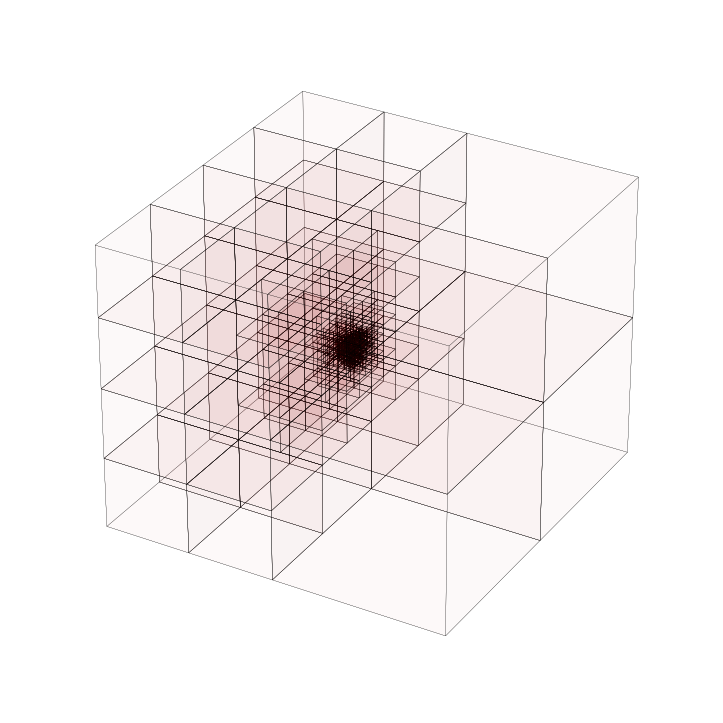

In [14]:
prod_tree = wideG_tree * narrowG_tree
print(prod_tree)
prod_tree.crop(0.1*prec)
print(prod_tree)
grid_plotter(prod_tree)

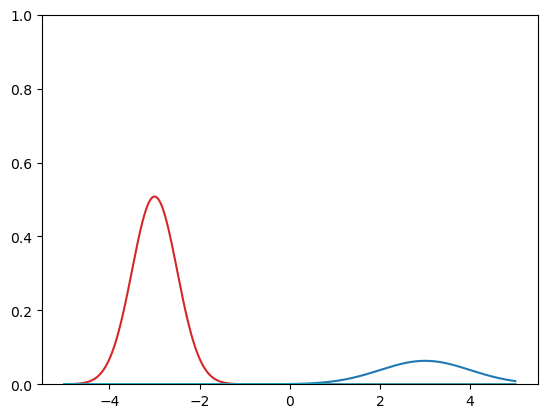

In [15]:
import matplotlib.pyplot as plt
x_vec = np.linspace(-5,5,1001)
y1_vec = np.array([narrowG_tree([x,0.0,0.0]) for x in x_vec ])
y2_vec = np.array([wideG_tree([x,0.0,0.0]) for x in x_vec ])
y3_vec = np.array([sum_tree([x,0.0,0.0]) for x in x_vec ])
y4_vec = np.array([prod_tree([x,0.0,0.0]) for x in x_vec ])
plt.plot(x_vec, y1_vec, "tab:red") # potential from narrow Gaussian
plt.plot(x_vec, y2_vec, "tab:blue") # potential from wide Gaussian
#plt.plot(x_vec, y3_vec, "tab:green") # point charge potential
plt.plot(x_vec, 10000 * y4_vec, "tab:cyan") # point charge potential
plt.ylim(0.0,1.0)
plt.show()